# Demonstration of Continuous Test & Learn
## Multi arm bandit experiement

Assumption:

-4 campaign offer in total

-Customer will be shown the offer and he can decide whether to click it

-A click means a positive response

In [109]:
num_offer_action = 4
true_offer_click_probabilities = [0.2,0.7,0.65,0.45]

In [110]:
from collections import Counter
import numpy as np
import random

random.seed(54)
np.random.seed(54)

# To count how many times each offer is shown
# counter = Counter()

def show_offer_and_collect_response(offer_idx,true_offer_click_probabilities,counter):
    counter[offer_idx] += 1
    if np.random.random() < true_offer_click_probabilities[offer_idx]:
        return 'Click'
    else:
        return 'Ignore'

Start with a uniform discrete prior

In [111]:
from empiricaldist import Pmf
from scipy.stats import binom

def create_prior_belief(num_offer_action):
    probs = np.linspace(0,1,1001)
    prior_belief = Pmf(1,probs)
    prior_belief.normalize()

    prior_believes = [prior_belief.copy() for i in range(num_offer_action)]
    
    return prior_believes
    
est_offer_click_probabilities = create_prior_belief(num_offer_action)

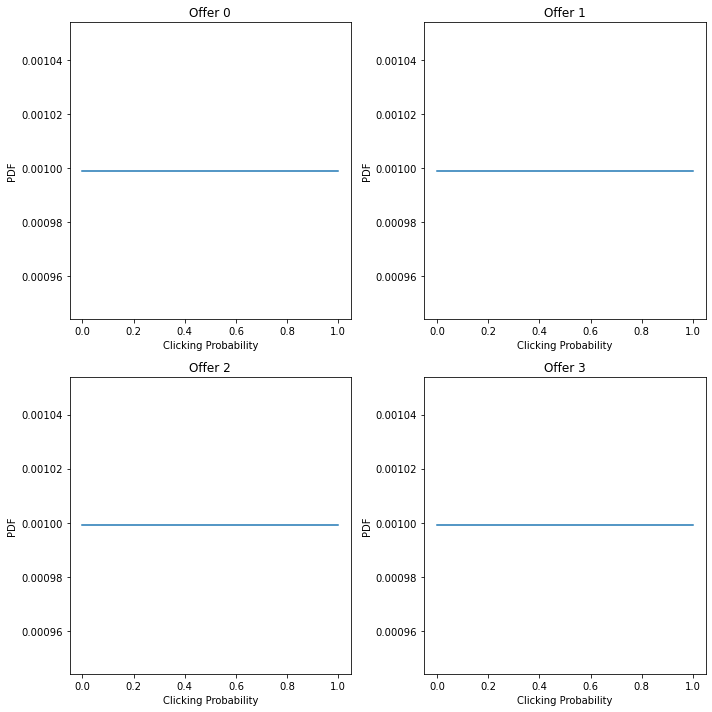

In [112]:
import matplotlib.pyplot as plt

def plot(est_offer_click_probabilities):
    f,axes = plt.subplots(2,2,figsize=(10,10))
    axe = axes.ravel()
    for offer_idx,pmf in enumerate(est_offer_click_probabilities):
        pmf.plot(title='Offer %s' % offer_idx,ax=axe[offer_idx])
        axe[offer_idx].set_xlabel("Clicking Probability")
        axe[offer_idx].set_ylabel("PDF")
    f.tight_layout()
        
plot(est_offer_click_probabilities)

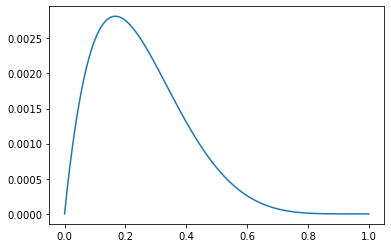

In [113]:
def update(pmf,impression_result):
    likelihood = {
        'Click':probs,
        'Ignore':1-probs
    }
    pmf *= likelihood[impression_result]
    pmf.normalize()
    
test_offer = prior_offer_click_probabilities.copy()
for result in ['Click','Ignore','Ignore','Ignore','Ignore','Ignore']:
    update(test_offer,result)
    
test_offer.plot()

In [114]:
counter = Counter()
for offer_idx in range(num_offer_action):
    for steps in range(10):
        result = show_offer_and_collect_response(offer_idx,true_offer_click_probabilities,counter)
        update(est_offer_click_probabilities[offer_idx],result)

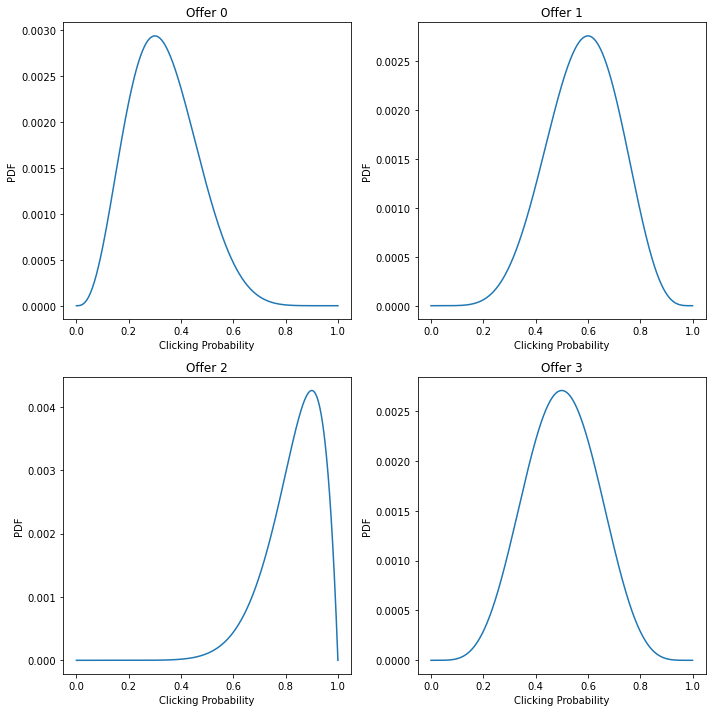

In [115]:
plot(est_offer_click_probabilities)

Thomson Sampling

An exploration strategy to choose offer with the largest clicking probability

In [126]:
def choose_campaign_action_offer(est_belief):
    """
    Use Thomson Sampling to choose
    Draw one sample from each offer's distribution
    
    """
    sample_believes = [b.choice(1) for b in est_belief]
    return np.argmax(sample_believes)

Summarize everything

And take 1000 trials

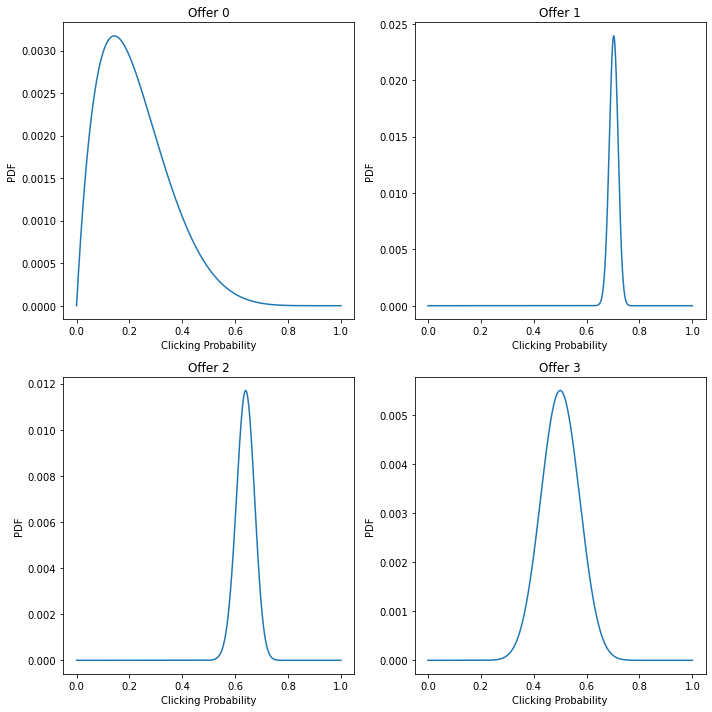

In [129]:
num_offer_action = 4
true_offer_click_probabilities = [0.2,0.7,0.65,0.45]

def test_and_learn_strategy(est_offer_click_probabilities,offer_counter,click_counter):
    choice_offer_idx = choose_campaign_action_offer(est_offer_click_probabilities)
    
    result = show_offer_and_collect_response(choice_offer_idx,true_offer_click_probabilities,offer_counter)
    
    result_binary = 1 if result=='Click' else 0
    click_counter[choice_offer_idx] += result_binary
    
    update(est_offer_click_probabilities[choice_offer_idx],result)
    
del est_offer_click_probabilities
est_offer_click_probabilities = create_prior_belief(num_offer_action)

num_trials = 1000
offer_counter = Counter()
click_counter = Counter()

for _ in range(num_trials):
    test_and_learn_strategy(est_offer_click_probabilities,offer_counter,click_counter)
    
plot(est_offer_click_probabilities)

Evaluate the estimation

In [130]:
import pandas as pd

columns = ['Actual P(Click)', 
           'Posterior mean', 
           'Credible interval']

df = pd.DataFrame(columns=columns)
for i, b in enumerate(est_offer_click_probabilities):
    mean = np.round(b.mean(), 3)
    ci = b.credible_interval(0.9)
    ci = np.round(ci, 3)
    df.loc[i] = true_offer_click_probabilities[i], mean, ci

df

,Actual P(Click),Posterior mean,Credible interval
0,0.20,0.222,"[0.046, 0.471]"
1,0.70,0.702,"[0.674, 0.729]"
2,0.65,0.638,"[0.582, 0.693]"
3,0.45,0.500,"[0.382, 0.618]"


In [133]:
index = range(num_offer_action)
columns = ['Actual P(Click)', 'Times showed','Times clicked']
df = pd.DataFrame(index=index, columns=columns)
for i, count in offer_counter.items():
    df.loc[i,'Actual P(Click)'] = true_offer_click_probabilities[i]
    df.loc[i,'Times showed'] = count

for i, click_count in click_counter.items():
    df.loc[i,'Times clicked'] = click_count
    
df

,Actual P(Click),Times showed,Times clicked
0,0.2,7,1
1,0.7,750,527
2,0.65,197,126
3,0.45,46,23


In [138]:
print(f"response_rate: {(df['Times clicked'].sum()/1000)*100}%")

response_rate: 67.7%


Using Beta prior distribution instead

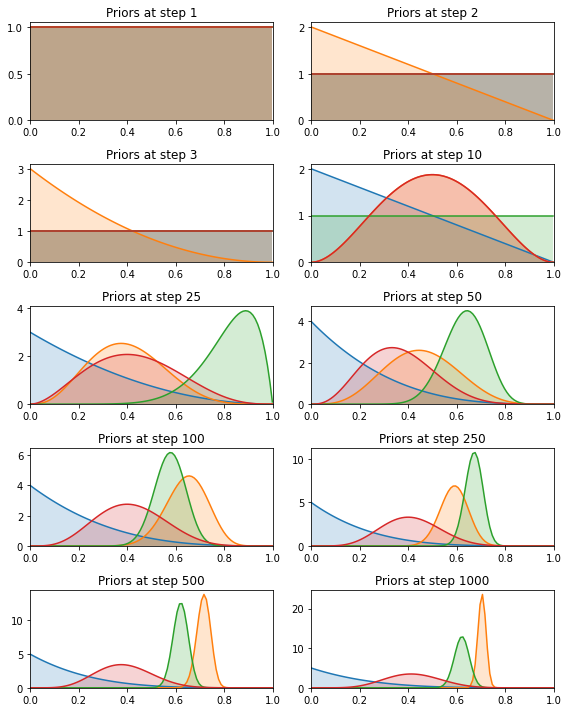

In [127]:
from scipy.stats import beta

def choose_campaign_action_offer_scipy(est_belief):
    """
    Use Thomson Sampling to choose
    Draw one sample from each offer's distribution
    
    """
    sample_believes = [b.rvs(1) for b in est_belief]
    return np.argmax(sample_believes)

num_trials = 1000
num_offer_action = 4
true_offer_click_probabilities = [0.2,0.7,0.65,0.45]
offer_counter = Counter()
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

trials = [0]*num_offer_action
clicks = [0]*num_offer_action

for trial in range(1,num_trials+1):
    est_offer_click_probabilities = [beta(a=1+c,b=1+t-c) for t,c in zip(trials,clicks)]
    
    if trial in [1,2,3,10,25,50,100,250,500,1000]:
        ax = next(axs)
        plot_x = np.linspace(0.001, .999, 100)
        for est_offer_click_probabilitie in est_offer_click_probabilities:
            y = est_offer_click_probabilitie.pdf(plot_x)
            p = ax.plot(plot_x, y)
            ax.fill_between(plot_x, y, 0, alpha=0.2)
        ax.set_xlim([0, 1])
        ax.set_ylim(bottom=0)
        ax.set_title(f'Priors at step {trial:d}')
        
    choice_offer_idx = choose_campaign_action_offer_scipy(est_offer_click_probabilities)
    
    result = show_offer_and_collect_response(choice_offer_idx,true_offer_click_probabilities,offer_counter)
    
    result = 1 if result=='Click' else 0
    
    trials[choice_offer_idx] += 1
    clicks[choice_offer_idx] += result

fig.tight_layout()